In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('../raw_data/data_preparation.csv', index_col=[0])
pd.set_option("display.max_columns", None)

In [3]:
#df_energy_weather.isnull().sum()

In [4]:
df['cos_day']

0       0.623490
1      -0.222521
2      -0.900969
3      -0.900969
4      -0.222521
          ...   
3412   -0.222521
3413   -0.900969
3414   -0.900969
3415   -0.222521
3416    0.623490
Name: cos_day, Length: 3417, dtype: float64

In [5]:
X = df.drop(columns=['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30','YEAR', 'MONTH', 'DAY', 
                     'season', 'num_day', 'sin365_2', 'cos365_2',
       'sin365_3', 'cos365_3'])


In [6]:
X.columns

Index(['T2M', 'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
       'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS50M', 'sin_month',
       'cos_month', 'week_day', 'sin_day', 'cos_day', 'bank_holiday',
       'school_holidays', 'sin365_1', 'cos365_1'],
      dtype='object')

In [7]:
y = df['Consommation (MW)']

In [8]:
preproc_numerical_baseline = make_pipeline(
    MinMaxScaler())

In [9]:
preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    remainder="drop")

In [10]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(3417, 22)

In [11]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x176b25dc0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [12]:
from sklearn.metrics import mean_absolute_percentage_error

In [13]:
from sklearn.model_selection import cross_val_score
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')
score_baseline.mean()

-0.05057376858324562

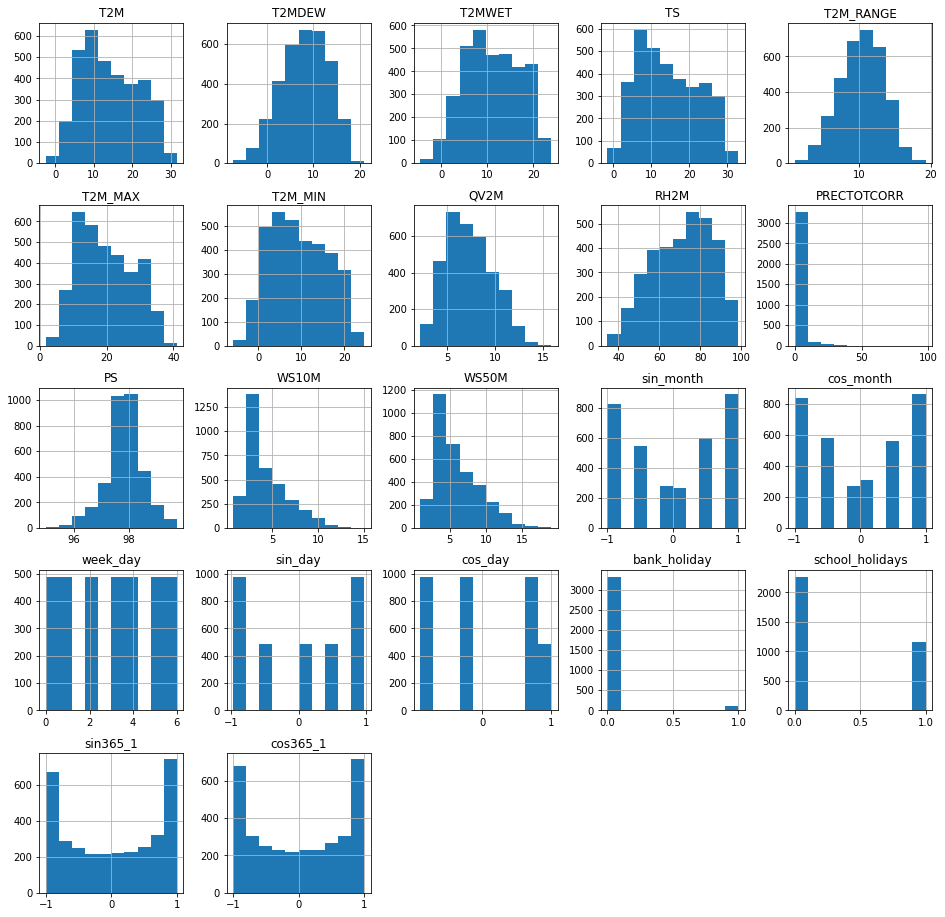

In [14]:
import matplotlib.pyplot as plt
X.hist(figsize=(16,16))
plt.show()

# random forest

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
preproc_StandardScaler = make_pipeline(StandardScaler()) 
preproc_RobustScaler = make_pipeline( RobustScaler())

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
#min_max = ['week_day']
stand = ['T2MDEW','T2M_RANGE']
robus = ['T2M', 'T2MWET', 'TS', 'T2M_MAX', 'T2M_MIN','QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 
         'WS10M', 'WS50M']


In [19]:
preproc = make_column_transformer(
    (preproc_StandardScaler, stand),
    (preproc_RobustScaler, robus),
    remainder="passthrough")

preproc



ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['T2MDEW', 'T2M_RANGE']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['T2M', 'T2MWET', 'TS', 'T2M_MAX', 'T2M_MIN',
                                  'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M',
                                  'WS50M'])])

In [20]:
#preproc.fit_transform(X).shape

In [21]:
pipe_final_rf = make_pipeline(preproc, RandomForestRegressor())

In [22]:
cv_result_rf = cross_val_score(pipe_final_rf, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')

In [23]:
cv_result_rf

array([-0.03451521, -0.03247743, -0.03180031, -0.05119136, -0.03664862])

In [24]:
cv_result_rf.mean()

-0.03732658428441522

In [25]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 280, stop = 340, num = 4)]
# Number of features to consider at every split
max_features = [2, 3] #['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(70, 80, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 6, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5,6] 
# Method of selecting samples for training each tree
#bootstrap = [True, False]

In [27]:
grid = {'randomforestregressor__n_estimators': n_estimators,
        'randomforestregressor__max_features': [1.0,0.8],
        'randomforestregressor__max_depth': max_depth,
        'randomforestregressor__min_samples_split': min_samples_split,
        'randomforestregressor__min_samples_leaf': min_samples_leaf,
               }




In [28]:
pipe_final_rf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['T2MDEW', 'T2M_RANGE']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['T2M', 'T2MWET', 'TS',
                                                   'T2M_MAX', 'T2M_MIN', 'QV2M',
                                                   'RH2M', 'PRECTOTCORR', 'PS',
                                                   'WS10M', 'WS50M'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [29]:
grid

{'randomforestregressor__n_estimators': [280, 300, 320, 340],
 'randomforestregressor__max_features': [1.0, 0.8],
 'randomforestregressor__max_depth': [70, 75, 80, None],
 'randomforestregressor__min_samples_split': [5, 6, 7],
 'randomforestregressor__min_samples_leaf': [5, 6]}

In [30]:
#grid_search.get_params()

In [32]:
'''
{'n_estimators': [1800],
 'min_samples_split': [2],
 'min_samples_leaf': [2],
 'max_features': ['auto'],
 'max_depth': [80],
 'bootstrap': True}
'''

"\n{'n_estimators': [1800],\n 'min_samples_split': [2],\n 'min_samples_leaf': [2],\n 'max_features': ['auto'],\n 'max_depth': [80],\n 'bootstrap': True}\n"

In [33]:
from xgboost import XGBRegressor

In [34]:
#pipe_final_xgb = make_pipeline(preproc, XGBRegressor(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    #nthread=1))
    
#xgb_test = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)
xgb_test = XGBRegressor(max_depth=12, n_estimators=300, learning_rate=0.1)

pipe_final_xgb_test = make_pipeline(preproc, xgb_test)

In [35]:
pipe_final_xgb_test.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler())]),
                                    ['T2MDEW', 'T2M_RANGE']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('robustscaler',
                                                     RobustScaler())]),
                                    ['T2M', 'T2MWET', 'TS', 'T2M_MAX', 'T2M_MIN',
                                     'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M',
                                     'WS50M'])])),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categ

In [36]:
cv_result_xgb = cross_val_score(pipe_final_xgb_test, X, y, cv=5, scoring='neg_mean_absolute_percentage_error',error_score='raise')

In [37]:
cv_result_xgb

array([-0.03432967, -0.03251306, -0.03258455, -0.04860132, -0.03451478])

In [38]:
params = {
        'xgbregressor__min_child_weight': [6,7,8],
        'xgbregressor__gamma': [0.1,0.2],
        'xgbregressor__subsample': [0.8],
        'xgbregressor__colsample_bytree': [1.0],
        'xgbregressor__n_estimators': [50,100, 150],
        'xgbregressor__max_depth': [16,18,20]
        }

In [39]:
'''
{'xgbregressor__colsample_bytree': 1.0,
 'xgbregressor__gamma': 0.2,
 'xgbregressor__max_depth': 16,
 'xgbregressor__min_child_weight': 6,
 'xgbregressor__n_estimators': 100,
 'xgbregressor__subsample': 0.8}'''

"\n{'xgbregressor__colsample_bytree': 1.0,\n 'xgbregressor__gamma': 0.2,\n 'xgbregressor__max_depth': 16,\n 'xgbregressor__min_child_weight': 6,\n 'xgbregressor__n_estimators': 100,\n 'xgbregressor__subsample': 0.8}"

In [40]:
# -0.03595265869360382 / -0.035882640044610004

# test sur un an

In [52]:
#df = df[ (df["Date"] <= 31) & (df["day"].isnull() == False) ]
df_train = df[ (df["Date"] <= '2020-12-31')]
df_test = df[ (df["Date"] > '2020-12-31') & (df["Date"] <= '2021-12-31')]

In [53]:
df_train = df[ (df["Date"] <= '2020-12-31')]
df_test = df[ (df["Date"] > '2020-12-31') & (df["Date"] <= '2021-12-31')]

In [54]:
X_train = df_train.drop(columns=['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30','YEAR', 'MONTH', 'DAY', 'season', 'num_day'])

y_train = df_train['Consommation (MW)']

In [55]:
X_test = df_test.drop(columns=['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30','YEAR', 'MONTH', 'DAY', 'season', 'num_day'])

y_test = df_test['Consommation (MW)']

In [56]:
best_params = {'xgbregressor__colsample_bytree': 1.0,
                 'xgbregressor__gamma': 0.1,
                 'xgbregressor__max_depth': 16,
                 'xgbregressor__min_child_weight': 6,
                 'xgbregressor__n_estimators': 100,
                 'xgbregressor__subsample': 0.8}

In [57]:
X_train_preproc = preproc.fit_transform(X_train, y_train)
X_test_preproc = preproc.transform(X_test)

In [58]:
X_train_preproc[0]

array([-0.38293916, -1.49960992, -0.53641428, -0.45818182, -0.50572985,
       -0.70701462, -0.47783138, -0.27683616,  0.86088481,  8.6023166 ,
       -0.12543554, -0.11881188,  0.03053435,  0.5       ,  0.8660254 ,
        1.        ,  0.78183148,  0.6234898 ,  1.        ,  1.        ,
        0.01720158,  0.99985204,  0.03439806,  0.99940821,  0.06875541,
        0.99763355])

In [59]:
'''
model_xgb.fit(X_train_preproc, y_train,
        )verbose=False,
        eval_set=[(X_train_preproc, y_train), (X_eval_preproc, y_eval_log)],
        eval_metric=["rmse"],
        early_stopping_rounds=10)


model_xgb = (estimator = pipe_final_xgb_test, param_grid = best_params, 
                          cv = 5, n_jobs = -1, verbose = 5, scoring ='neg_mean_absolute_percentage_error')
'''
#model_xgb = XGBRegressor(parameters = best_params, learning_rate=0.1)


# 'xgbregressor__subsample': 0.8 <---- ?????

model_xgb = XGBRegressor(colsample_bytree = 1, 
                         gamma= 0.1, 
                         max_depth= 16, 
                         min_child_weight= 6, 
                         n_estimators= 100,
                         learning_rate=0.1)

model_xgb.fit(X_train_preproc, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [60]:
y_pred = model_xgb.predict(X_test)

In [61]:
y_pred

array([230887.1 , 234788.28, 228621.78, 235759.9 , 234267.36, 235310.95,
       236629.3 , 235236.11, 230864.95, 224494.67, 237601.33, 233976.48,
       243056.53, 241763.03, 234207.44, 226985.3 , 229146.66, 233247.33,
       235179.58, 243717.39, 242610.05, 239961.89, 243528.17, 237202.3 ,
       234073.83, 235519.3 , 235117.11, 242164.81, 241688.9 , 238388.47,
       233983.56, 239766.75, 238804.16, 239539.47, 239464.31, 240100.69,
       239756.72, 234576.22, 238031.78, 240108.97, 240593.69, 232696.55,
       240406.69, 240045.34, 222075.39, 227870.42, 236245.88, 236207.69,
       234513.12, 232988.28, 228293.81, 221719.16, 232965.94, 230853.28,
       230091.38, 229691.56, 230966.03, 226875.25, 219511.34, 231142.34,
       231204.5 , 231730.72, 231302.62, 231738.25, 224933.  , 218905.84,
       229771.67, 229534.56, 224135.12, 227395.25, 227208.19, 221616.84,
       213670.75, 226247.1 , 223731.39, 225354.16, 225632.89, 224851.22,
       220203.39, 203695.02, 213240.45, 226626.84, 

In [62]:
y_test = y_test.to_numpy()
y_test


array([283815., 294157., 296424., 320426., 327553., 333186., 344509.,
       331284., 315895., 308919., 320284., 332291., 303061., 290395.,
       289936., 296561., 286982., 301997., 308888., 292757., 279861.,
       274355., 272271., 266877., 282578., 299206., 297047., 277571.,
       255817., 251802., 243462., 254005., 252750., 250564., 251257.,
       241377., 228547., 232002., 261618., 259856., 250904., 259393.,
       275743., 276089., 285766., 298649., 289979., 264965., 269223.,
       258081., 237463., 227769., 243238., 232700., 233233., 235816.,
       234181., 231916., 219691., 231551., 246308., 252541., 253797.,
       238657., 230851., 222402., 233869., 240486., 239498., 239602.,
       228348., 221472., 217923., 235871., 239850., 239986., 249608.,
       265051., 250550., 244967., 245013., 238020., 230958., 224751.,
       220834., 201198., 199342., 207275., 201684., 196458., 199192.,
       198348., 188497., 187183., 191195., 209185., 234456., 237695.,
       228281., 2186

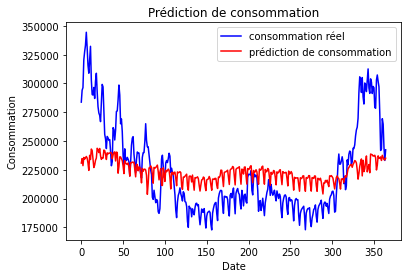

In [63]:
plt.figure()#figsize=(10,6)
plt.plot(y_test, color='blue', label='consommation réel')
plt.plot(y_pred , color='red', label='prédiction de consommation')
plt.title('Prédiction de consommation')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show()